In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

Algoritmos Geneticos
==================

# Introduccion

## Definiciones

* Gen: una ciudad (representada como coordenadas (x, y))
* Individuo (también conocido como "cromosoma"): una sola ruta que satisface las condiciones anteriores
* Población: una colección de rutas posibles (es decir, una colección de individuos)
* Padres: dos rutas que se combinan para crear una nueva ruta
* Grupo de apareamiento: una colección de padres que se utilizan para crear nuestra próxima población (creando así la próxima generación de rutas)
* Fitness: una función que nos dice qué tan buena es cada ruta (en nuestro caso, qué tan corta es la distancia)
* Mutación: una forma de introducir variación en nuestra población intercambiando aleatoriamente dos ciudades en una ruta
* Elitismo: una forma de llevar a los mejores individuos a la próxima generación

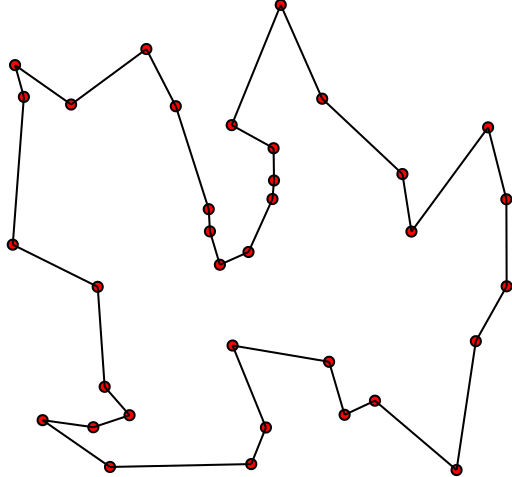

## Algoritmo

1. Crear la población

2. Determinar fitness

3. Seleccion de individuos

4. Mezcla/Crossover

5. Mutar

6. Repetir

Este proceso se itera hasta que no se logran mejoras de la optimización es decir que el algoritmo converja.


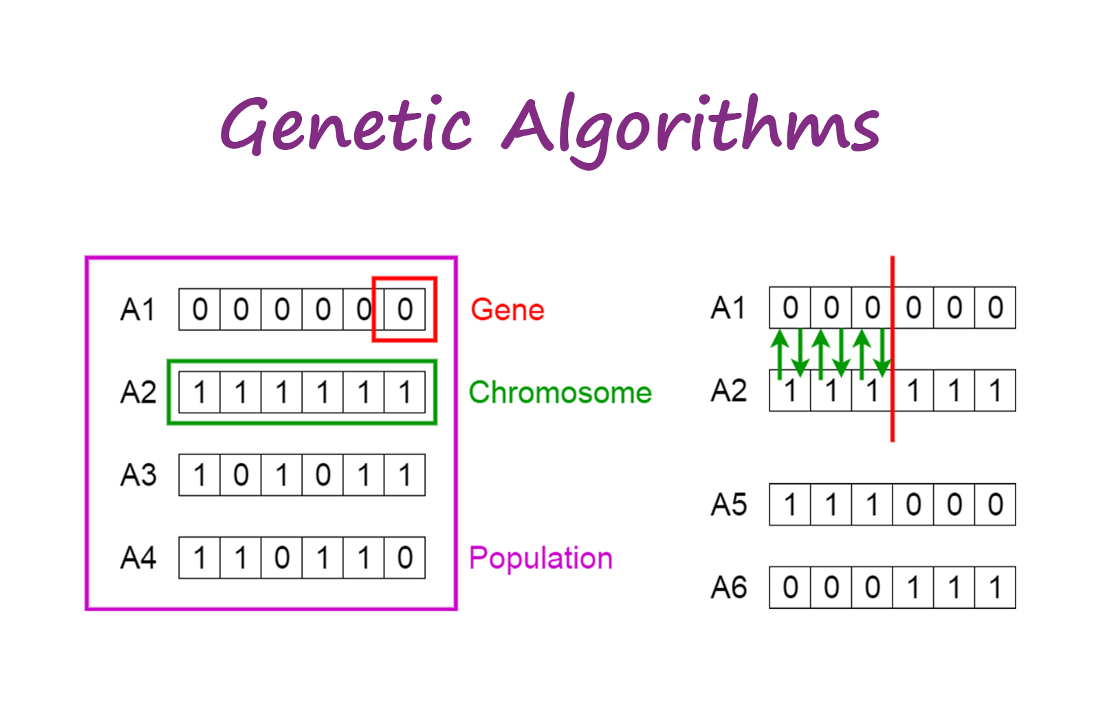

## Seleccion

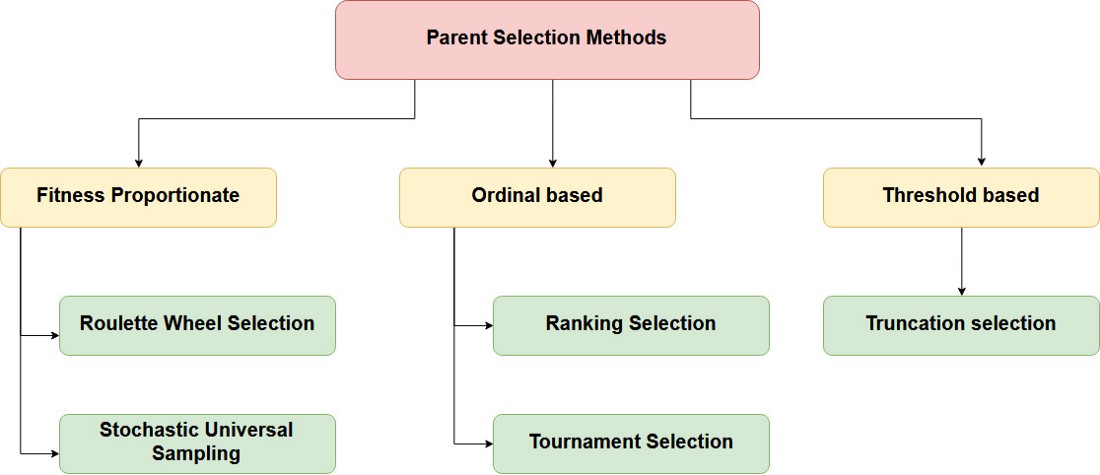

###  Roulette Wheel Selection / Fitness proportionate selection

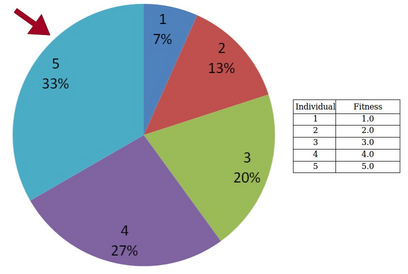


### Stochastic universal sampling

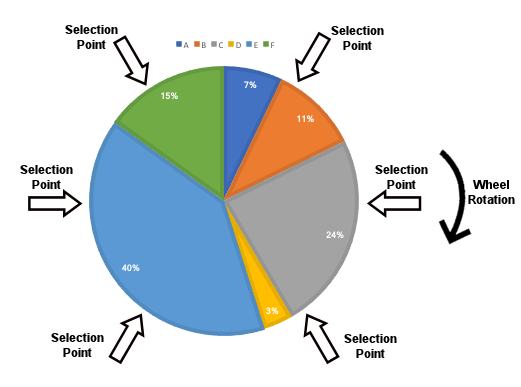

### Rank Selection

En este metodo:
1. Se ordenan los individuos segun su fitness
2. Se generan probabilidades en base al orden del ranking.
   Eg: Si la poblacion es de 10 se generan puntajes 0.1,0.2,0.3,...,1.0 y luego se dividen por el total para obtener numeros del 0 al 1.
3. Con esas probabilidades se lleva a cabo el metodo de la ruleta.

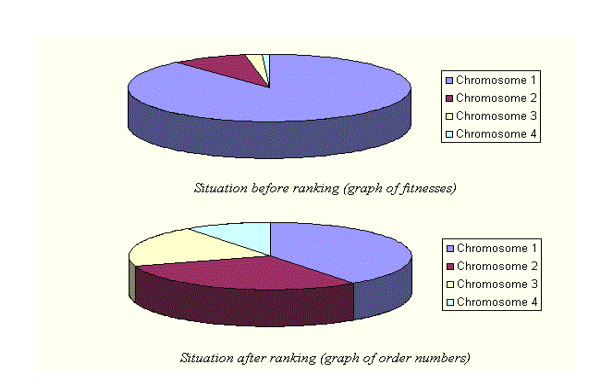

## Tournament Selection

En este método se toman K individuos de manera aleatoria y luego se elige el mejor.

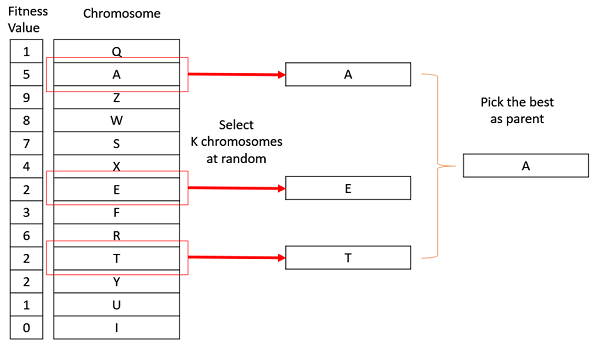

# Implementacion

## Clase para modelar ciudades

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

## Clase para calcular el fitness de una ruta

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0
    
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Creamos la poblacion inicial

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Seleccion

In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

## Crossover de Individuos

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [9]:
def breed(parent1, parent2):
    """Crossover function for two parents to create one child"""
    child = []
    childP1 = []
    childP2 = []
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    for i in range(startGene, endGene):
        childP1.append(parent1[i])
    childP2 = [item for item in parent2 if item not in childP1]
    child = childP1 + childP2
    return child

In [10]:
def breedPopulation(matingpool, eliteSize):
    """Run crossover over full mating pool."""
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))
    for i in range(0,eliteSize):
        children.append(matingpool[i])
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

## Mutación

In [11]:
def mutate(individual, mutationRate):
    """Mutate a single route"""
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [12]:
def mutatePopulation(population, mutationRate):
    """Mutate population."""
    mutatedPop = []
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

## Generar próxima generación

In [13]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    """Create the next generation."""
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [14]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Corriendo el algoritmo

Create list of cities

In [22]:
cityList = []
for i in range(0, 20):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [25]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        ranked_routes = rankRoutes(pop)
        bestRouteIndex = ranked_routes[0][0]
        bestRoute = pop[bestRouteIndex]
        print(f"[{i+1}/{generations}] Current best route score: {ranked_routes[0][1]}")
        # print(f"Current best route: {bestRoute}")
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

[1/500] Current best route score: 0.0006442657277924453
[2/500] Current best route score: 0.0006442657277924453
[3/500] Current best route score: 0.0006354945391892471
[4/500] Current best route score: 0.0006568627928508875
[5/500] Current best route score: 0.0007014892845434085
[6/500] Current best route score: 0.000749358307472274
[7/500] Current best route score: 0.000749358307472274
[8/500] Current best route score: 0.000749358307472274
[9/500] Current best route score: 0.000749358307472274
[10/500] Current best route score: 0.000749358307472274
[11/500] Current best route score: 0.000749358307472274
[12/500] Current best route score: 0.0007748528624047144
[13/500] Current best route score: 0.0007748528624047144
[14/500] Current best route score: 0.0008494688869693006
[15/500] Current best route score: 0.0008395326047033241
[16/500] Current best route score: 0.0008395326047033241
[17/500] Current best route score: 0.0008395326047033241
[18/500] Current best route score: 0.000872268

[145/500] Current best route score: 0.001135327736272584
[146/500] Current best route score: 0.001135327736272584
[147/500] Current best route score: 0.001135327736272584
[148/500] Current best route score: 0.001135327736272584
[149/500] Current best route score: 0.001135327736272584
[150/500] Current best route score: 0.001135327736272584
[151/500] Current best route score: 0.001135327736272584
[152/500] Current best route score: 0.0011399879837803951
[153/500] Current best route score: 0.0011399879837803951
[154/500] Current best route score: 0.001135327736272584
[155/500] Current best route score: 0.001135327736272584
[156/500] Current best route score: 0.0011412433649733223
[157/500] Current best route score: 0.0011412433649733223
[158/500] Current best route score: 0.0011412433649733223
[159/500] Current best route score: 0.0011412433649733223
[160/500] Current best route score: 0.0011412433649733223
[161/500] Current best route score: 0.0011412433649733223
[162/500] Current best 

[287/500] Current best route score: 0.0012176695099265918
[288/500] Current best route score: 0.0012176695099265918
[289/500] Current best route score: 0.0012278581438500324
[290/500] Current best route score: 0.0012278581438500324
[291/500] Current best route score: 0.0012278581438500324
[292/500] Current best route score: 0.0012278581438500324
[293/500] Current best route score: 0.0012278581438500324
[294/500] Current best route score: 0.0012278581438500324
[295/500] Current best route score: 0.0012278581438500324
[296/500] Current best route score: 0.0012278581438500324
[297/500] Current best route score: 0.0012176695099265918
[298/500] Current best route score: 0.0012278581438500327
[299/500] Current best route score: 0.0012278581438500327
[300/500] Current best route score: 0.0012176695099265918
[301/500] Current best route score: 0.0012176695099265918
[302/500] Current best route score: 0.0012176695099265918
[303/500] Current best route score: 0.0012176695099265918
[304/500] Curr

[430/500] Current best route score: 0.001238226813806711
[431/500] Current best route score: 0.001238226813806711
[432/500] Current best route score: 0.001238226813806711
[433/500] Current best route score: 0.001238226813806711
[434/500] Current best route score: 0.0012382268138067113
[435/500] Current best route score: 0.0012382268138067113
[436/500] Current best route score: 0.0012382268138067113
[437/500] Current best route score: 0.0012382268138067113
[438/500] Current best route score: 0.0012382268138067113
[439/500] Current best route score: 0.0012382268138067113
[440/500] Current best route score: 0.0012382268138067113
[441/500] Current best route score: 0.0012382268138067113
[442/500] Current best route score: 0.0012382268138067113
[443/500] Current best route score: 0.0012382268138067113
[444/500] Current best route score: 0.0012382268138067113
[445/500] Current best route score: 0.0012382268138067113
[446/500] Current best route score: 0.0012382268138067113
[447/500] Current 

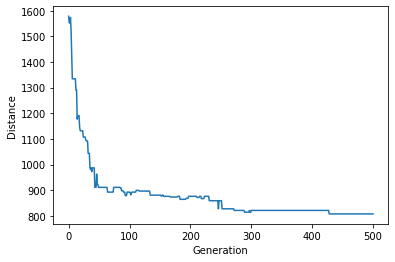

In [26]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

## References

* https://en.wikipedia.org/wiki/Genetic_algorithm
* https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3
* https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
* https://github.com/mstpn/PyGAD_TSP/blob/main/PyGAD_TSP.ipynb
* https://medium.datadriveninvestor.com/genetic-algorithms-selection-5634cfc45d78
* https://en.wikipedia.org/wiki/Stochastic_universal_sampling
* https://en.wikipedia.org/wiki/Fitness_proportionate_selection

### Instrucciones para generar slides

https://www.dev2qa.com/how-to-create-slideshow-from-jupyter-notebook